# Projet Data Science - HMIN232 - 2020/2021

**Membres du groupe :**
- Antoine Brahimi
- Antoine Barbier
- Ahmed Kaci
- Djamel Benameur
- Guillem Blanchard

**Description du projet :** Ce projet a pour but de proposer des modèles de classification supervisée d'assertions faites par des figures politiques selon leur valeur de véracité, ou autrement dit, de proposer une approche de fact-checking automatique.

Pour ce projet, on utilise un jeu de données collecté par le LIRMM à partir de différents sites de fact-checking. Les données ont été récupéré dans différents fichiers au format CSV.













## I. import des différentes bibliothèque




In [ ]:
import sys
import csv
import glob, os 
import pandas as pd
import numpy as np
import seaborn as sns
from enum import Enum
from typing import Dict

import time
import matplotlib.pyplot as plt

from sklearn_pandas import DataFrameMapper
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

#Sickit learn met régulièrement à jour des versions et indique des futurs warnings.
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import inflect
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

from textblob import TextBlob

from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##  Import et convertion des fichiers CSV en dataframe

Nos données sont contenu dans différents fichier CSV car lors de la récupération de ces dernières à partir du site "data.gesis.org/claimskg/explorer/home" on ne pouvait pas récupérer dans des fichier plus de 10 000 lignes. On a donc différents fichiers avec des assertions de type : vrai, faux et mixture. Nous n'avons pas récupérer les assertions "other" car elle sont inutile pour ce projet.

In [ ]:
#lecture du fichier dans un dataframe
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Colab Notebooks/EGC_Ecole2021/claimskg
%ls
dataframe=pd.DataFrame()
dataframe = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "./*.csv"))))

class NormalizedRatings(Enum):
    FALSE = 1
    MIXTURE = 2
    TRUE = 3
    OTHER = -1


_normalization_dictionary = {  # type: Dict[str, Dict[str,NormalizedRatings]]

    "politifact": {  # type: Dict[str,NormalizedRatings]
        'incorrect': NormalizedRatings.FALSE,
        'pants-fire': NormalizedRatings.FALSE,
        'pants on fire': NormalizedRatings.FALSE,
        'pants on fire!': NormalizedRatings.FALSE,
        'false': NormalizedRatings.FALSE,
        'mostly correct': NormalizedRatings.MIXTURE,
        'mostly false': NormalizedRatings.MIXTURE,
        'barely true': NormalizedRatings.MIXTURE,
        'half true': NormalizedRatings.MIXTURE,
        'half-true': NormalizedRatings.MIXTURE,
        'mostly true': NormalizedRatings.MIXTURE,
        'true': NormalizedRatings.TRUE,
        'correct': NormalizedRatings.TRUE
    },
    "snopes": {  # type: Dict[str,NormalizedRatings]
        'false': NormalizedRatings.FALSE,
        'legend': NormalizedRatings.FALSE,
        'mixture': NormalizedRatings.MIXTURE,
        'mixture:': NormalizedRatings.MIXTURE,
        'true': NormalizedRatings.TRUE,
        'mostly false': NormalizedRatings.MIXTURE,
        'mostly true': NormalizedRatings.MIXTURE,
        'partly true': NormalizedRatings.MIXTURE,
        'MIXTURE OF TRUE AND FALSE INFORMATION': NormalizedRatings.MIXTURE,
        'MIXTURE OF TRUE AND FALSE INFORMATION:': NormalizedRatings.MIXTURE,
        'MIXTURE OF ACCURATE AND  INACCURATE INFORMATION': NormalizedRatings.MIXTURE
    },
    "africacheck": {  # type: Dict[str,NormalizedRatings]
        'incorrect': NormalizedRatings.FALSE,
        'mostly-correct': NormalizedRatings.MIXTURE,
        'correct': NormalizedRatings.TRUE
    },
    "factscan": {  # type: Dict[str,NormalizedRatings]
        'false': NormalizedRatings.FALSE,
        'true': NormalizedRatings.TRUE,
        'Misleading': NormalizedRatings.OTHER
    },
    "truthorfiction": {  # type: Dict[str,NormalizedRatings]
        'fiction': NormalizedRatings.FALSE,
        'truth': NormalizedRatings.TRUE,
        'truth & fiction': NormalizedRatings.MIXTURE,
        'mostly fiction': NormalizedRatings.MIXTURE,
        'truth & misleading': NormalizedRatings.MIXTURE,
        'mostly truth': NormalizedRatings.MIXTURE
    },
    "checkyourfact": {  # type: Dict[str,NormalizedRatings]
        'False': NormalizedRatings.FALSE,
        'True': NormalizedRatings.TRUE,
        'Mostly True': NormalizedRatings.MIXTURE,
        'true/false': NormalizedRatings.MIXTURE,
        'truth & misleading': NormalizedRatings.MIXTURE,
        'mostly truth': NormalizedRatings.MIXTURE,
        'misleading': NormalizedRatings.MIXTURE
    },
    "factcheck_aap": {
        "True": NormalizedRatings.TRUE,
        "False": NormalizedRatings.FALSE,
        "Mostly True": NormalizedRatings.MIXTURE,
        "Mostly False": NormalizedRatings.MIXTURE,
        "Somewhat True": NormalizedRatings.MIXTURE,
        "Somewhat False": NormalizedRatings.MIXTURE
    },
    "factuel_afp_fr": {
        'Faux': NormalizedRatings.FALSE,
        'Totalement faux': NormalizedRatings.FALSE,
        'Démenti': NormalizedRatings.FALSE,
        "C'est une oeuvre de fiction": NormalizedRatings.FALSE,
        'Vrai': NormalizedRatings.TRUE,
        'Totalement Vrai': NormalizedRatings.TRUE,
        'Plutôt vrai': NormalizedRatings.MIXTURE,
        'Trompeur': NormalizedRatings.MIXTURE,
        'trompeur': NormalizedRatings.MIXTURE,
        'Plutôt faux': NormalizedRatings.MIXTURE,
        'Presque': NormalizedRatings.MIXTURE,
        'Mélangé': NormalizedRatings.MIXTURE,
        'Mélange': NormalizedRatings.MIXTURE,
        'Inexact': NormalizedRatings.MIXTURE,
        'Incertain': NormalizedRatings.MIXTURE,
        'Imprécis': NormalizedRatings.MIXTURE,
        'Exagéré': NormalizedRatings.MIXTURE,
        'Douteux': NormalizedRatings.MIXTURE,

    },
    "factcheck_afp": {
        'False': NormalizedRatings.FALSE,
        'Fake': NormalizedRatings.FALSE,
        'Mixed': NormalizedRatings.MIXTURE,
        'Hoax': NormalizedRatings.FALSE,
        'Falso': NormalizedRatings.FALSE,
        'APRIL FOOL': NormalizedRatings.FALSE
    },
    "fullfact": {
        'Correct': NormalizedRatings.TRUE,
        'Incorrect': NormalizedRatings.FALSE,
        'Not quite': NormalizedRatings.MIXTURE
    }
}


def _standardize_name(original_name: str):
    return original_name.strip().lower().replace("!", "").replace(":", "").replace("-", " ")


def normalize(source_name, original_name) -> NormalizedRatings:
    """
        Generate a normalized rating from the original ratings on each respective site
    :param original_name:
    :return normalized_rating: NormalizedRating
    """
    try:
        source = _normalization_dictionary[source_name]
        normalized_value = source[_standardize_name(original_name)]
    except KeyError:
        normalized_value = NormalizedRatings.OTHER
    return normalized_value

row, col = dataframe.shape
print("taille du  dataframe :" + str(dataframe.size) + " ("+str(row)+"*"+str(col)+")")
dataframe.head()

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/EGC_Ecole2021/claimskg
claimskg_result_False1.csv    claimskg_result_Mixture2.csv
claimskg_result_False2.csv    claimskg_result_True.csv
claimskg_result_Mixture1.csv
taille du  dataframe :387940 (27710*14)


id  ... language
0  http://data.gesis.org/claimskg/claim_review/cc...  ...  English
1  http://data.gesis.org/claimskg/claim_review/43...  ...  English
2  http://data.gesis.org/claimskg/claim_review/9d...  ...  English
3  http://data.gesis.org/claimskg/claim_review/37...  ...  English
4  http://data.gesis.org/claimskg/claim_review/08...  ...  English

[5 rows x 14 columns]

##Visualisation des données contenu dans le dataframe

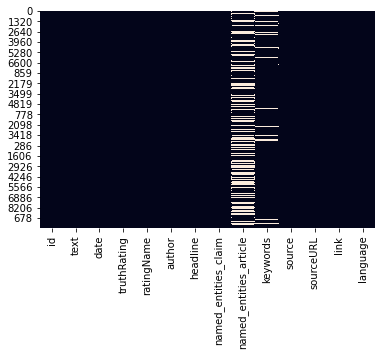

In [ ]:
dataframe=dataframe.replace("[]",np.NaN)
sns.heatmap(dataframe.isnull(), cbar=False)

##création d'un dataframe contenant uniquement les colonnes que nous jugeons utiles et supression des lignes ayant des valeurs null

taille du  dataframe :81435 (16287*5)


text  ... truthRating
0  'There are more young black males involved in ...  ...           1
2  Michigan and Massachusetts raised their bottle...  ...           1
3  Except for Virginia, 'the other 49 states keep...  ...           1
4  In the Senate version of the health reform bil...  ...           1
5  'We don’t have a (military) reserve force if s...  ...           1

[5 rows x 5 columns]

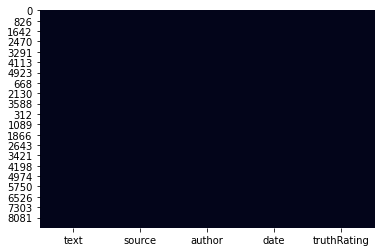

In [ ]:
dataframe = dataframe[['text', 'source', 'author', 'date', 'truthRating']]
dataframe=dataframe.replace("[]",np.NaN) 
dataframe=dataframe.replace("Unknown",np.NaN)
dataframe=dataframe.dropna()
sns.heatmap(dataframe.isnull(), cbar=False)
row, col = dataframe.shape
print("taille du  dataframe :" + str(dataframe.size) + " ("+str(row)+"*"+str(col)+")")
dataframe.head()

## Création des Dataframes pour la classification des données brutes

In [ ]:
# Création dataframeVF brut
dataframe3_VF_brut = pd.concat([dataframe[dataframe['truthRating']==1], dataframe[dataframe['truthRating']==3]], axis=0)

row, col = dataframe3_VF_brut.shape
print("taille du  dataframeVF brut:" + str(dataframe3_VF_brut.size) + " ("+str(row)+"*"+str(col)+")")

# Création dataframe3_VF_vs_M_brut
dataframe3_VF_vs_M_brut = dataframe.copy()
dataframe3_VF_vs_M_brut['truthRating']=dataframe3_VF_vs_M_brut['truthRating'].apply(lambda x: 1 if x == 1 or x == 3 else 0)

row, col = dataframe3_VF_vs_M_brut.shape
print("taille du  dataframeVFvsM brut:" + str(dataframe3_VF_vs_M_brut.size) + " ("+str(row)+"*"+str(col)+")")

# Création dataframe3_V_vs_F_vs_M_brut
dataframe3_V_vs_F_vs_M_brut = dataframe.copy()

row, col = dataframe3_V_vs_F_vs_M_brut.shape
print("taille du  dataframeVvsFvsM brut:" + str(dataframe3_V_vs_F_vs_M_brut.size) + " ("+str(row)+"*"+str(col)+")")

taille du  dataframeVF brut:37240 (7448*5)
taille du  dataframeVFvsM brut:81435 (16287*5)
taille du  dataframeVvsFvsM brut:81435 (16287*5)


## Prétraitement : 



### Pré-traitement :Transformation des valeurs numériques en mots dans la colone text
**texte en gras**

In [ ]:
def transform_numbers(text):
  tokens = word_tokenize(text)
  p = inflect.engine()
  for word in tokens:
    if word.isdigit():
      text=text.replace(word,p.number_to_words(word))
  return text
dataframe["text"] = dataframe["text"].apply(lambda text: transform_numbers(str(text)))
dataframe.head()


text  ... truthRating
0  'There are more young black males involved in ...  ...           1
2  Michigan and Massachusetts raised their bottle...  ...           1
3  Except for Virginia, 'the other forty-nine sta...  ...           1
4  In the Senate version of the health reform bil...  ...           1
5  'We don’t have a (military) reserve force if s...  ...           1

[5 rows x 5 columns]

### Pré-traitement : Lowering case

Cette étape permet de convertir les valeurs des champs "text", "author" et "source" dans le même format de caractères.

In [ ]:
#prétraitement sur la colone text du dataframe
#lowering case 
def toLowerCase(text): 
    return text.lower()

dataframe["text"] = dataframe["text"].apply(lambda text: toLowerCase(text))
dataframe["author"] = dataframe["author"].apply(lambda text: toLowerCase(text))
dataframe["source"] = dataframe["source"].apply(lambda text: toLowerCase(text))
dataframe.head()


text  ... truthRating
0  'there are more young black males involved in ...  ...           1
2  michigan and massachusetts raised their bottle...  ...           1
3  except for virginia, 'the other forty-nine sta...  ...           1
4  in the senate version of the health reform bil...  ...           1
5  'we don’t have a (military) reserve force if s...  ...           1

[5 rows x 5 columns]

### Pré-traitement : Suppressions de la ponctuation dans la colone text

On supprime la ponctuation dans notre dataframe (pour la colone text) car elle ne nous apporte aucune informations sur la valeur de véracité d'une assertion et sont inutiles pour l'étape de classification.

In [ ]:
#remove ponctuation
def remove_punctuation(text):
  punct = '''!()-_—“–[]{};:’”'‘"\,<>./?@#$%^&*_~…'''
  for c in punct:
    text = text.replace(c, " ")
  return text   
dataframe["text"] = dataframe["text"].apply(lambda text: remove_punctuation(text))
dataframe.head()

text  ... truthRating
0   there are more young black males involved in ...  ...           1
2  michigan and massachusetts raised their bottle...  ...           1
3  except for virginia   the other forty nine sta...  ...           1
4  in the senate version of the health reform bil...  ...           1
5   we don t have a  military  reserve force if s...  ...           1

[5 rows x 5 columns]

### Pré-traitement : Suppression des STOP WORDS dans la colone text

Les stop-word sont des mots très courrant et regulier dans les langages, ils n'apportent donc pas d'informations permettant de déterminer la véracité d'une assertion.

Voici quelques exemples de stop words en anglais : 
" into, me, is, a, do, here, than ..."

Pour supprimer les stop words de notre dataframe, nous utilisons la bibliothèque "nltk" importer si dessus, qui nous fournit une liste contentant une grande partie des stop words (en effet il n'existe pas d'unique liste contenant tous les stop words existant).

In [ ]:
#remove stopwords
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word.lower() not in STOPWORDS])
dataframe["text"] = dataframe["text"].apply(lambda text: remove_stopwords(text))
dataframe.head()


text  ... truthRating
0  young black males involved criminal justice sy...  ...           1
2  michigan massachusetts raised bottle deposit c...  ...           1
3  except virginia forty nine states keep raising...  ...           1
4  senate version health reform bill every enroll...  ...           1
5           military reserve force something happens  ...           1

[5 rows x 5 columns]

### Pré-traitement : Correction orthographique dans la colonne text

Pour cette étape, nous utilisons la bibliotéque textblob, qui nous fournie des fonctions permettant d'effectuer la correction orthographique sur la colone text de notre dataframe.




In [ ]:
#spelling correction
def spellingCorrection(text):
  for word in text.split():
    word2 =str(TextBlob(word).correct())
    text=text.replace(word,word2)
  return text
dataframe["text"] = dataframe["text"].apply(lambda text: spellingCorrection(text))
dataframe.head()

text  ... truthRating
0  young black males involved criminal justice sy...  ...           1
2  michigan massachusetts raised bottle deposit c...  ...           1
3  except virginia forty nine states keep raising...  ...           1
4  senate version health reform bill every enroll...  ...           1
5           military reserve force something happens  ...           1

[5 rows x 5 columns]

### Pré-traitement : Suppressions des mots communs de la colonne text

Cette étape permet de supprimer les plus fréquents mots du langage. Ces mots étant trop nombreux, n'apportent pas une grande utilité pour les algorithmes de classification. 

On a donc fait le choix de supprimer les 15 mots les plus fréquent dans nos assertions.

In [ ]:
#common word removal
from collections import Counter
def count_nb_occ_word(textColumnOfDataframe):
  counter = Counter()
  for text in textColumnOfDataframe.values:
    for word in text.split():
      counter[word] += 1
  return counter
  
def removeWord(text,word):
  if word in text.split():
   # print(word)
    text=text.replace(word,"")
  return text

counter = count_nb_occ_word(dataframe["text"])
print("Les 15 mots les plus fréquents (les mots qui seront supprimés)")
print(counter.most_common(15))
wordsToRemove=counter.most_common(15)
for word in wordsToRemove :
  dataframe["text"]=dataframe["text"].apply(lambda text: removeWord(text,word[0]))
dataframe["text"].head()


Les 15 mots les plus fréquents (les mots qui seront supprimés)
[('says', 4046), ('one', 1982), ('two', 1819), ('percent', 1776), ('state', 1346), ('thousand', 1308), ('drama', 1279), ('hundred', 1179), ('000', 1149), ('tax', 1088), ('president', 1035), ('people', 1034), ('year', 993), ('years', 955), ('health', 912)]


0    young black males involved criminal justice sy...
2    michigan massachusetts raised bottle deposit c...
3    except virginia forty nine states keep raising...
4    senate version  reform bill every enrolled off...
5             military reserve force something happens
Name: text, dtype: object

### Pré-traitement : Suppressions des mots rares dans la colonne text

Tout comme les mots communs, les mots rare ne nous apportent pas d'informations fiable pour connaitre la véracité d'une assertion.

In [ ]:
#rare word removal

def count_nb_occ_word(textColumnOfDataframe):
  counter = Counter()
  for text in textColumnOfDataframe.values:
    for word in text.split():
      counter[word] += 1
  return counter
  
def removeWord(text,word):
  if word in text.split():
    text=text.replace(word,"")
  return text
        
counter = count_nb_occ_word(dataframe["text"])
for word in counter :
  if counter[word]<3 :
    dataframe["text"]=dataframe["text"].apply(lambda text: removeWord(text,word))
dataframe.head()


text  ... truthRating
0  young black males involved criminal justice sy...  ...           1
2  michigan massachusetts raised bottle deposit c...  ...           1
3  except virginia forty nine states keep raising...  ...           1
4  senate version  reform bill every enrolled off...  ...           1
5           military reserve force something happens  ...           1

[5 rows x 5 columns]

### Pré-traitement : Lématization de la colonne text

L'étape de lématisation est l'opération qui consiste à réduire chaque mot à sa racine.

In [ ]:
#lematization

from nltk.stem import PorterStemmer

def lematisation(text):
  porter = PorterStemmer()
  for word in text.split():
    word2 =porter.stem(word)
    text=text.replace(word,word2)
  return text
dataframe["text"] = dataframe["text"].apply(lambda text:lematisation(text))
dataframe.head()

text  ... truthRating
0  young black male involv crimin justic system h...  ...           1
2  michigan massachusett rais bottl deposit could...  ...           1
3     except virginia forti nine state keep rais ga   ...           1
4  senat version  reform bill everi enrol offic p...  ...           1
5                 militari reserv forc someth happen  ...           1

[5 rows x 5 columns]

### Pré-traitement : Traitement des dates 
Les algorithmes de classification ne permettent pas la manipulation de données sous le formats date, car elle ne manipule que des nombre. Ainsi nous avant décomposé la colone date en trois colones numérique contenant respectivement le jour le mois et l'année. 

In [ ]:
#traitement des dates 
dataframe2=dataframe.copy()
dataframe2["date"] = dataframe2["date"].astype(str)

dataframe2["date"] =  pd.to_datetime(dataframe2["date"])

# Reset our index so datetime_utc becomes a column

# Create new columns
dataframe2['day'] = dataframe2["date"].dt.day
dataframe2['month'] = dataframe2["date"].dt.month
dataframe2['year'] = dataframe2["date"].dt.year

dataframe2 = dataframe2[['text', 'source', 'author', 'day', 'month', 'year', 'truthRating']]
dataframe2.head(10)

text  ... truthRating
0   young black male involv crimin justic system h...  ...           1
2   michigan massachusett rais bottl deposit could...  ...           1
3      except virginia forti nine state keep rais ga   ...           1
4   senat version  reform bill everi enrol offic p...  ...           1
5                  militari reserv forc someth happen  ...           1
6                                      back  rais tax  ...           1
7           elimin obamacar save nineti five billion   ...           1
8    donald tramp said believ suicid comber deserv...  ...           1
9   recent  rep  sponsor legisl would increas spen...  ...           1
10                 deni said  campaign play race card  ...           1

[10 rows x 7 columns]

## Création des Dataframes pour la classification des données prétraitées et non équilibrées

In [ ]:
# Création dataframeVF prétraitré non équilibré
dataframe3_VF_p_ne = pd.concat([dataframe2[dataframe2['truthRating']==1], dataframe2[dataframe2['truthRating']==3]], axis=0)

row, col = dataframe3_VF_p_ne.shape
print("taille du  dataframeVF prétraitré non équilibré:" + str(dataframe3_VF_p_ne.size) + " ("+str(row)+"*"+str(col)+")")

# Création dataframeVetFvsM prétraitré non équilibré
dataframe3_VF_vs_M_p_ne = dataframe2.copy()
dataframe3_VF_vs_M_p_ne['truthRating']=dataframe3_VF_vs_M_p_ne['truthRating'].apply(lambda x: 1 if x == 1 or x == 3 else 0)

row, col = dataframe3_VF_vs_M_p_ne.shape
print("taille du  dataframeVF prétraitré non équilibré:" + str(dataframe3_VF_vs_M_p_ne.size) + " ("+str(row)+"*"+str(col)+")")

# Création dataframeVvsFvsM prétraitré non équilibré
dataframe3_V_vs_F_vs_M_p_ne = dataframe2.copy()

row, col = dataframe3_V_vs_F_vs_M_p_ne.shape
print("taille du  dataframeVF prétraitré non équilibré:" + str(dataframe3_V_vs_F_vs_M_p_ne.size) + " ("+str(row)+"*"+str(col)+")")

taille du  dataframeVF prétraitré non équilibré:52136 (7448*7)
taille du  dataframeVF prétraitré non équilibré:114009 (16287*7)
taille du  dataframeVF prétraitré non équilibré:114009 (16287*7)


## II. Equilibrage des données




Repartition avant l'équilibrage: 
x=1 si Faux, x=2 si Mixture, x=3 si true, x=-1 si other


2    8839
1    5076
3    2372
Name: truthRating, dtype: int64




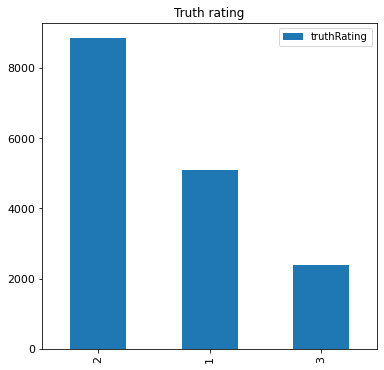

In [ ]:
#Contenu du dataframe après les prétraitements
import matplotlib.pyplot as plt

print("Repartition avant l'équilibrage: ")
print("x=1 si Faux, x=2 si Mixture, x=3 si true, x=-1 si other")
print("\n")
print(dataframe2["truthRating"].value_counts())
print("\n")
dataframe2["truthRating"].value_counts().plot(kind='bar', 
                                  figsize=(6,6),
                                  title='Truth rating', 
                                  fontsize=11, 
                                  legend=True)
plt.show()

Comme le montre les résultats ci dessus il ya 5076 valeur FALSE, 8839 valeur Mixture, 2372 valeur TRUE, ces résultats déséquilibré risques fausser les résultats des classifications. Pour cela nous avons décidé d’y remédier en appliquant le UPSAMPLING ET DOWNSAMPLING des classes que nous avons vue en cours.

Upsampling des lignes du dataframe ayant la valeur de véracité TRUE et Downsample des lignes ayant la valeur de véracité Mixture pour équilibrer totues les données (nombre de TRUE = nombre de FALSE = nombre de MIXTURE).</br>
Création des dataframes qui seront utilisé pour les classifications TRUE vs FALSE et TRUE vs FALSE vs MIXTURE.

In [ ]:
##équilibrage des données (UPSAMPLING ET DOWNSAMPLING) 
nbFalse= len(dataframe2[dataframe2.truthRating == 1].index);
print("nombre de False ",nbFalse)
dataframeF = dataframe2[dataframe2['truthRating']==1]

dataframeV = dataframe2[dataframe2['truthRating']==3] 

dataframeVup = dataframeV.sample(nbFalse,replace=True)



row, col = dataframeVup.shape
print("taille du  dataframe ne contenant que des valeurs true (pour test après upsampling) :" + str(dataframeVup.size) + " ("+str(row)+"*"+str(col)+")")
dataframeM = dataframe2[dataframe2['truthRating']==2]
dataframeMdown = dataframeM.sample(nbFalse)
row, col = dataframeMdown.shape
print("taille du  dataframe ne contenant que des valeurs Mixture (pour test après downsampling) :" + str(dataframeMdown.size) + " ("+str(row)+"*"+str(col)+")")

dataframeVF_equilibre = pd.concat([dataframeF, dataframeVup], axis=0)
dataframeVFM_equilibre = pd.concat([dataframeVF_equilibre, dataframeMdown], axis=0) 


nombre de False  5076
taille du  dataframe ne contenant que des valeurs true (pour test après upsampling) :35532 (5076*7)
taille du  dataframe ne contenant que des valeurs Mixture (pour test après downsampling) :35532 (5076*7)


True vs False: 
x=1 si Faux, x=2 , x=3 si true


3    5076
1    5076
Name: truthRating, dtype: int64




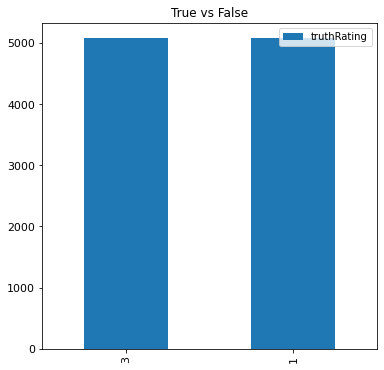

In [ ]:
#ne garder que les faux et vrai
#creation d'un nouveau dataframe qui contiendra que les vrai et faux

print("True vs False: ")
print("x=1 si Faux, x=2 , x=3 si true")
print("\n")
print(dataframeVF_equilibre["truthRating"].value_counts())
print("\n")

dataframeVF_equilibre["truthRating"].value_counts().plot(kind='bar', 
                                  figsize=(6,6),
                                  title='True vs False', 
                                  fontsize=11, 
                                  legend=True)

plt.show()

Création du dataframe, qui sera utilisé pour la cassification TRUE /FALSE vs MIXTURE, équilibré suite à des opérations de upsamling et de downsampling.

TrueFalse vs Mixture: 
x=1 si vrai/faux, x=0 si mixture


nombre d'élément du df vrai faux vs mixture 1    5076
0    5076
Name: truthRating, dtype: int64




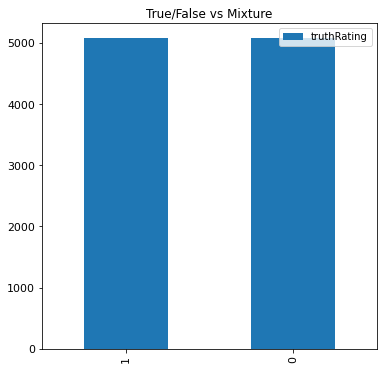

In [ ]:
#ne garder que VraiFaux vs mixture  
#on donne 1 si la valeur est vrai/faux et 0 si elle vaut mixture

dataframeVF_vs_M_Non_equilibre = dataframeVFM_equilibre.copy()

dataframeVF_vs_M_Non_equilibre['truthRating']=dataframeVF_vs_M_Non_equilibre['truthRating'].apply(lambda x: 1 if x == 1 or x == 3 else 0)
#équilibrage des VraiFaux vs mixture 
nbFalse = len(dataframe2[dataframe2.truthRating == 1].index)
moitierNbFalse =int(nbFalse/2)
dataframeFdown2 = dataframeF.sample(moitierNbFalse)
dataframeVup_down = dataframeVup.sample(moitierNbFalse)
dataframe_Demi_VF_equlibre = pd.concat([dataframeFdown2, dataframeVup_down], axis=0)
dataframeMdown2 = dataframeM.sample(nbFalse)
dataframe_Demi_VF_vs_M_equilibre =pd.concat([dataframe_Demi_VF_equlibre, dataframeMdown2], axis=0)
dataframe_Demi_VF_vs_M_equilibre['truthRating']=dataframe_Demi_VF_vs_M_equilibre['truthRating'].apply(lambda x: 1 if x == 1 or x == 3 else 0)

print("TrueFalse vs Mixture: ")
print("x=1 si vrai/faux, x=0 si mixture")
print("\n")
print("nombre d'élément du df vrai faux vs mixture",dataframe_Demi_VF_vs_M_equilibre["truthRating"].value_counts())
print("\n")
dataframe_Demi_VF_vs_M_equilibre["truthRating"].value_counts().plot(kind='bar', 
                                  figsize=(6,6),
                                  title='True/False vs Mixture', 
                                  fontsize=11, 
                                  legend=True)

plt.show()

True vs False vs Mixture: 


x=1 si False, x=2 si Mixture, x=3 si true
3    5076
2    5076
1    5076
Name: truthRating, dtype: int64


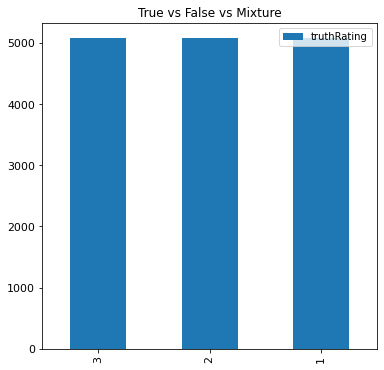

In [ ]:
#ne garder que Vrai vs Faux vs mixture 

print("True vs False vs Mixture: ")
print("\n")
print("x=1 si False, x=2 si Mixture, x=3 si true")
print(dataframeVFM_equilibre["truthRating"].value_counts())

dataframeVFM_equilibre["truthRating"].value_counts().plot(kind='bar', 
                                  figsize=(6,6),
                                  title='True vs False vs Mixture', 
                                  fontsize=11, 
                                  legend=True)

plt.show()

# III. Classifications 

En raison du fait que trop de RAM était utilisé lorsqu'on manipulait nos dataframes, on a dû tous les échantillonner à 5000 lignes.


## Classification VRAI vs FAUX

###Classification sur données brutes


#### Classification avec toutes les colonnes

In [ ]:
DVF = dataframe3_VF_brut.sample(5000)

#DVF = dataframeVF_equilibre.copy()
mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
  ('date', LabelEncoder()),],df_out=True)

X = mapper.fit_transform(DVF)
y = DVF['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   214.36148405075073
CART: 0.651400 (0.022019)
Time pour NB   126.7754454612732
NB: 0.410600 (0.015180)
Time pour RFO   514.4199953079224
RFO: 0.698400 (0.019795)
Time pour LR   122.6745994091034
LR: 0.685400 (0.020708)
Time pour LinearSVC   93.86034536361694
LinearSVC: 0.695800 (0.020774)
Time pour KNN   477.16454243659973
KNN: 0.655400 (0.018222)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

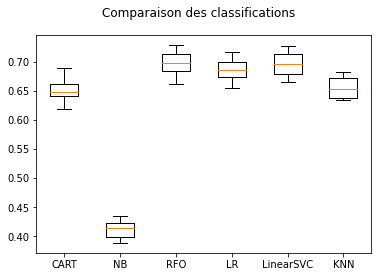

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

#### Classification sans la colonne date 

In [ ]:
DVF_sans_date = DVF.filter(['text','source','author','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
],df_out=True)

X = mapper.fit_transform(DVF_sans_date)
y = DVF_sans_date['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   159.5224678516388
CART: 0.655000 (0.015652)
Time pour NB   123.7627944946289
NB: 0.402200 (0.016011)
Time pour RFO   557.5822739601135
RFO: 0.698400 (0.020215)
Time pour LR   252.6901831626892
LR: 0.707800 (0.015886)
Time pour LinearSVC   109.55855083465576
LinearSVC: 0.706400 (0.021238)
Time pour KNN   597.2966933250427
KNN: 0.678200 (0.015164)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

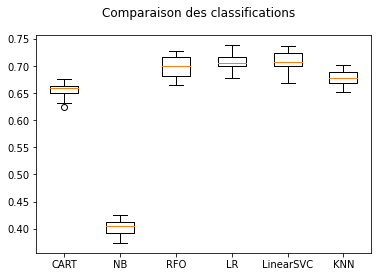

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

#### Classification sans la colonne auteur


In [ ]:
DVF_sans_auteur = DVF.filter(['text','source','date','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('date', LabelEncoder()),],df_out=True)

X = mapper.fit_transform(DVF_sans_auteur)
y = DVF_sans_auteur['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   281.44769167900085
CART: 0.650400 (0.028239)
Time pour NB   113.77307271957397
NB: 0.410600 (0.015101)
Time pour RFO   611.2760689258575
RFO: 0.702600 (0.021015)
Time pour LR   309.1245062351227
LR: 0.712200 (0.018941)
Time pour LinearSVC   110.04713487625122
LinearSVC: 0.687600 (0.020781)
Time pour KNN   595.2400319576263
KNN: 0.645400 (0.015442)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

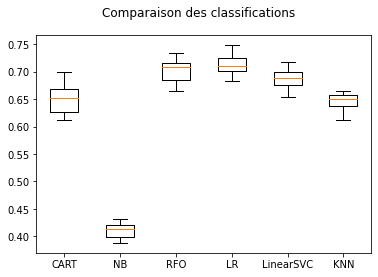

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

####Classification sans la colonne source

In [ ]:
DVF_sans_source = DVF.filter(['text','author','date','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('author', LabelEncoder()),
  ('date', LabelEncoder()),],df_out=True)

X = mapper.fit_transform(DVF_sans_source)
y = DVF_sans_source['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   220.84487533569336
CART: 0.659800 (0.020658)
Time pour NB   100.12695336341858
NB: 0.409200 (0.014483)
Time pour RFO   548.5760142803192
RFO: 0.696600 (0.020180)
Time pour LR   119.59738326072693
LR: 0.685400 (0.020708)
Time pour LinearSVC   103.21914076805115
LinearSVC: 0.688600 (0.020939)
Time pour KNN   603.5188910961151
KNN: 0.655400 (0.018222)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

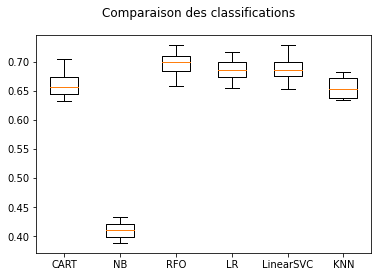

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

####Classification sans la colonne texte

In [ ]:
DVF_sans_texte = DVF.filter(['source','author','date','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
  ('date', LabelEncoder()),],df_out=True)

X = mapper.fit_transform(DVF_sans_texte)
y = DVF_sans_texte['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   0.17198920249938965
CART: 0.638600 (0.021186)
Time pour NB   0.04341387748718262
NB: 0.684200 (0.020385)
Time pour RFO   6.609299659729004
RFO: 0.667400 (0.024561)
Time pour LR   0.144456148147583
LR: 0.685400 (0.020708)
Time pour LinearSVC   0.07566261291503906
LinearSVC: 0.685400 (0.020708)
Time pour KNN   0.3411681652069092
KNN: 0.653400 (0.018068)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

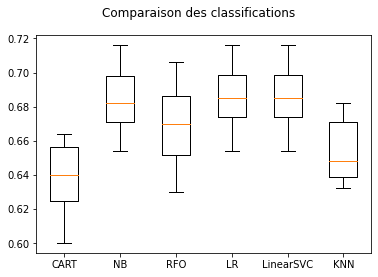

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

###Classification sur données prétraitées non équilibrées


#### Classification avec toutes les colonnes

In [ ]:
DVF = dataframe3_VF_p_ne.sample(5000)
#DVF = dataframeVF_equilibre.copy()
mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVF)
y = DVF['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   160.14620232582092
CART: 0.650600 (0.022451)
Time pour NB   61.28137254714966
NB: 0.451200 (0.009516)
Time pour RFO   456.79066920280457
RFO: 0.691000 (0.017601)
Time pour LR   210.4280092716217
LR: 0.693200 (0.023617)
Time pour LinearSVC   56.27818298339844
LinearSVC: 0.680400 (0.018885)
Time pour KNN   333.1424717903137
KNN: 0.639800 (0.015032)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

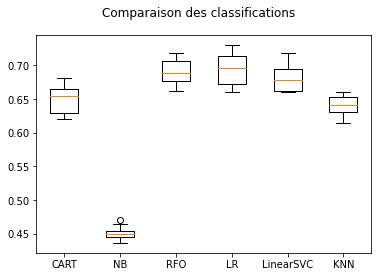

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

#### Classification sans la colonne date 

In [ ]:
DVF_sans_date = DVF.filter(['text','source','author','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
],df_out=True)

X = mapper.fit_transform(DVF_sans_date)
y = DVF_sans_date['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   143.72766709327698
CART: 0.655600 (0.018650)
Time pour NB   66.01089239120483
NB: 0.450600 (0.009922)
Time pour RFO   563.5774800777435
RFO: 0.693000 (0.018204)
Time pour LR   159.0139298439026
LR: 0.699600 (0.020333)
Time pour LinearSVC   52.673102617263794
LinearSVC: 0.694600 (0.018440)
Time pour KNN   370.9036068916321
KNN: 0.661800 (0.014127)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

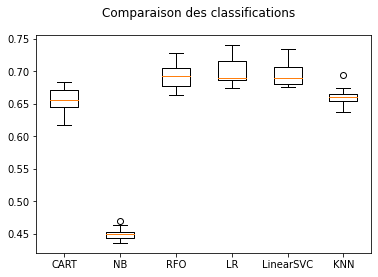

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

#### Classification sans la colonne auteur


In [ ]:
DVF_sans_auteur = DVF.filter(['text','source','day', 'month', 'year','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVF_sans_auteur)
y = DVF_sans_auteur['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   235.68565702438354
CART: 0.659800 (0.013578)
Time pour NB   79.0506911277771
NB: 0.609600 (0.013048)
Time pour RFO   529.5896277427673
RFO: 0.691400 (0.019474)
Time pour LR   251.95065689086914
LR: 0.698000 (0.017527)
Time pour LinearSVC   60.72504019737244
LinearSVC: 0.680800 (0.019415)
Time pour KNN   408.01249265670776
KNN: 0.631800 (0.024730)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

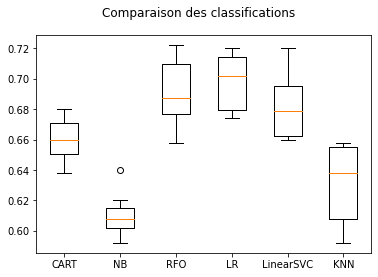

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

####Classification sans la colonne source

In [ ]:
DVF_sans_source = DVF.filter(['text','author','day', 'month', 'year','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('author', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVF_sans_source)
y = DVF_sans_source['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   165.71945762634277
CART: 0.659800 (0.015191)
Time pour NB   76.14509081840515
NB: 0.451200 (0.008998)
Time pour RFO   461.9865348339081
RFO: 0.690200 (0.017719)
Time pour LR   177.87348294258118
LR: 0.690000 (0.022574)
Time pour LinearSVC   65.80346083641052
LinearSVC: 0.681800 (0.021231)
Time pour KNN   380.03525042533875
KNN: 0.640000 (0.014940)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

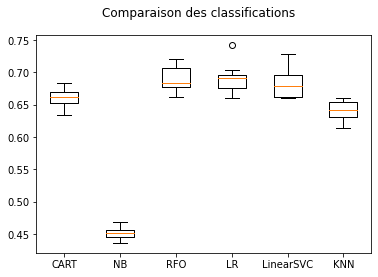

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

####Classification sans la colonne texte

In [ ]:
DVF_sans_texte = DVF.filter(['source','author','day', 'month', 'year','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVF_sans_texte)
y = DVF_sans_texte['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   0.16612005233764648
CART: 0.619600 (0.021425)
Time pour NB   0.04523897171020508
NB: 0.679200 (0.018335)
Time pour RFO   5.795166969299316
RFO: 0.656400 (0.018736)
Time pour LR   0.45838117599487305
LR: 0.680800 (0.019415)
Time pour LinearSVC   0.11681318283081055
LinearSVC: 0.680800 (0.019415)
Time pour KNN   0.3531670570373535
KNN: 0.641600 (0.016292)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

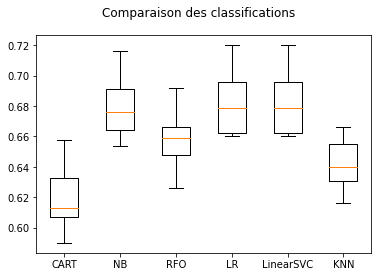

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

###Classification sur données équilibrées et prétraitées


#### Classification avec toutes les colonnes

In [ ]:
DVF = dataframeVF_equilibre.sample(5000)
#DVF = dataframeVF_equilibre.copy()
mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVF)
y = DVF['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   82.79955077171326
CART: 0.757800 (0.011574)
Time pour NB   67.38833665847778
NB: 0.608400 (0.015015)
Time pour RFO   364.0561194419861
RFO: 0.806800 (0.014865)
Time pour LR   178.48155999183655
LR: 0.662000 (0.088327)
Time pour LinearSVC   54.99844813346863
LinearSVC: 0.756600 (0.017890)
Time pour KNN   286.53824186325073
KNN: 0.682200 (0.019151)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

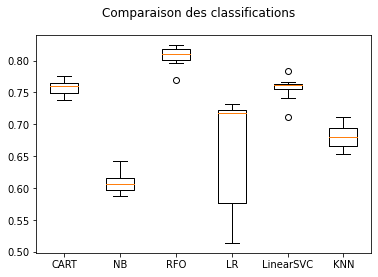

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

#### Classification sans la colonne date 

In [ ]:
DVF_sans_date = DVF.filter(['text','source','author','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
],df_out=True)

X = mapper.fit_transform(DVF_sans_date)
y = DVF_sans_date['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))
results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   95.4495496749878
CART: 0.753800 (0.015529)
Time pour NB   62.85314655303955
NB: 0.607800 (0.015348)
Time pour RFO   403.18055272102356
RFO: 0.807800 (0.014925)
Time pour LR   195.18467044830322
LR: 0.745800 (0.018707)
Time pour LinearSVC   56.92319583892822
LinearSVC: 0.759200 (0.016204)
Time pour KNN   322.3137254714966
KNN: 0.704000 (0.007537)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

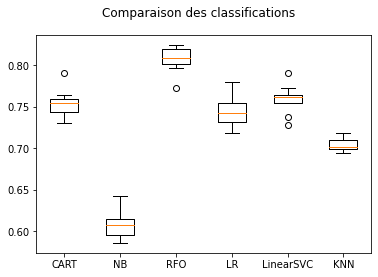

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

#### Classification sans la colonne auteur


In [ ]:
DVF_sans_auteur = DVF.filter(['text','source','day', 'month', 'year','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVF_sans_auteur)
y = DVF_sans_auteur['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   133.45881509780884
CART: 0.748800 (0.026400)
Time pour NB   64.01483654975891
NB: 0.716400 (0.019179)
Time pour RFO   408.0968487262726
RFO: 0.807400 (0.018763)
Time pour LR   162.80672407150269
LR: 0.687200 (0.093348)
Time pour LinearSVC   47.48616814613342
LinearSVC: 0.758000 (0.018719)
Time pour KNN   318.5349144935608
KNN: 0.645000 (0.023499)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

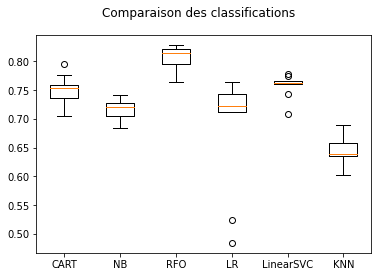

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

####Classification sans la colonne source

In [ ]:
DVF_sans_source = DVF.filter(['text','author','day', 'month', 'year','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('author', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVF_sans_source)
y = DVF_sans_source['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   77.69177865982056
CART: 0.758600 (0.014753)
Time pour NB   47.058027029037476
NB: 0.608000 (0.014751)
Time pour RFO   362.8460614681244
RFO: 0.809400 (0.021205)
Time pour LR   173.02115869522095
LR: 0.674000 (0.097648)
Time pour LinearSVC   48.88871717453003
LinearSVC: 0.756600 (0.017528)
Time pour KNN   307.0527148246765
KNN: 0.681800 (0.019130)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

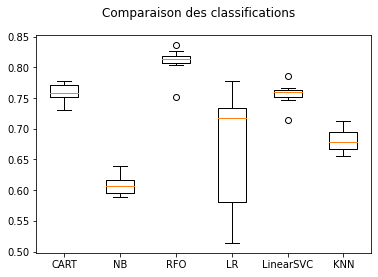

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

####Classification sans la colonne texte

In [ ]:
DVF_sans_texte = DVF.filter(['source','author','day', 'month', 'year','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVF_sans_texte)
y = DVF_sans_texte['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   0.15983891487121582
CART: 0.728800 (0.014593)
Time pour NB   0.04550814628601074
NB: 0.588400 (0.032751)
Time pour RFO   5.757611513137817
RFO: 0.750000 (0.024803)
Time pour LR   0.42290496826171875
LR: 0.522800 (0.015702)
Time pour LinearSVC   0.14045953750610352
LinearSVC: 0.521600 (0.019428)
Time pour KNN   0.35412120819091797
KNN: 0.681800 (0.020089)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

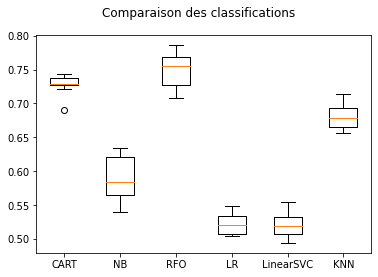

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

## Classification VRAI & FAUX vs MIXTURE 

###Classification sur données brutes

#### Classification avec toutes les colonnes

In [ ]:
DVFvsM = dataframe3_VF_vs_M_brut.sample(5000)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
  ('date', LabelEncoder()),],df_out=True)

X = mapper.fit_transform(DVFvsM)
y = DVFvsM['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   225.59725499153137
CART: 0.559000 (0.021246)
Time pour NB   165.15969395637512
NB: 0.579600 (0.024311)
Time pour RFO   606.867799282074
RFO: 0.591600 (0.019956)
Time pour LR   148.9935712814331
LR: 0.549600 (0.012027)
Time pour LinearSVC   130.16649079322815
LinearSVC: 0.584200 (0.019523)
Time pour KNN   659.7788972854614
KNN: 0.542800 (0.021302)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

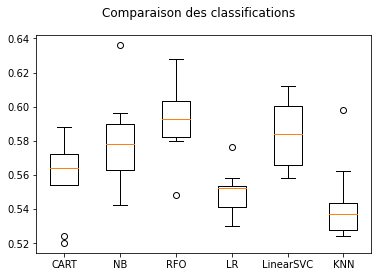

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

#### Classification sans la colonne date 

In [ ]:
DVFvsM_sans_date = DVFvsM.filter(['text','source','author','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
],df_out=True)

X = mapper.fit_transform(DVFvsM_sans_date)
y = DVFvsM_sans_date['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   233.6430163383484
CART: 0.539600 (0.012986)
Time pour NB   119.13880729675293
NB: 0.568400 (0.025136)
Time pour RFO   626.3360333442688
RFO: 0.580400 (0.018062)
Time pour LR   154.7190716266632
LR: 0.565400 (0.013477)
Time pour LinearSVC   94.39727830886841
LinearSVC: 0.586200 (0.017354)
Time pour KNN   527.5080833435059
KNN: 0.559200 (0.017645)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

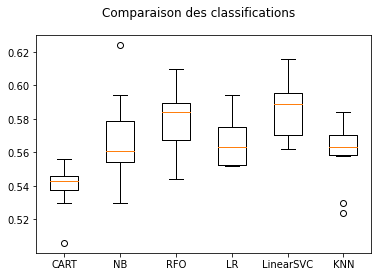

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

#### Classification sans la colonne auteur


In [ ]:
DVFvsM_sans_auteur = DVFvsM.filter(['text','source','date','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('date', LabelEncoder()),],df_out=True)

X = mapper.fit_transform(DVFvsM_sans_auteur)
y = DVFvsM_sans_auteur['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   289.64546298980713
CART: 0.550800 (0.023259)
Time pour NB   159.7190661430359
NB: 0.579200 (0.024318)
Time pour RFO   593.7533419132233
RFO: 0.584000 (0.022804)
Time pour LR   165.59663653373718
LR: 0.549600 (0.012027)
Time pour LinearSVC   150.95539379119873
LinearSVC: 0.578800 (0.018400)
Time pour KNN   603.7190990447998
KNN: 0.537000 (0.024597)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

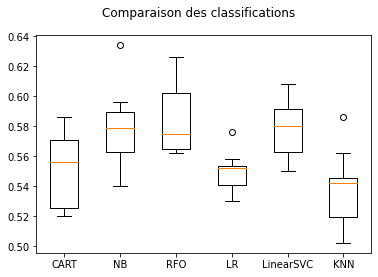

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

####Classification sans la colonne source

In [ ]:
DVFvsM_sans_source = DVFvsM.filter(['text','author','date','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('author', LabelEncoder()),
  ('date', LabelEncoder()),],df_out=True)

X = mapper.fit_transform(DVFvsM_sans_source)
y = DVFvsM_sans_source['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   223.47098207473755
CART: 0.558800 (0.023583)
Time pour NB   142.1083526611328
NB: 0.570800 (0.025880)
Time pour RFO   606.8829646110535
RFO: 0.578400 (0.019795)
Time pour LR   121.7272322177887
LR: 0.549600 (0.012027)
Time pour LinearSVC   117.38626265525818
LinearSVC: 0.582200 (0.023485)
Time pour KNN   522.635936498642
KNN: 0.542800 (0.021302)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

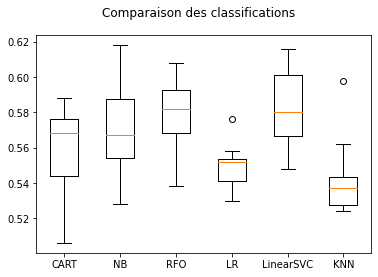

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

####Classification sans la colonne texte

In [ ]:
DVFvsM_sans_texte = DVFvsM.filter(['source','author','date','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
  ('date', LabelEncoder()),],df_out=True)

X = mapper.fit_transform(DVFvsM_sans_texte)
y = DVFvsM_sans_texte['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   0.19188332557678223
CART: 0.561400 (0.016051)
Time pour NB   0.03948783874511719
NB: 0.556400 (0.010500)
Time pour RFO   7.200797080993652
RFO: 0.566200 (0.019969)
Time pour LR   0.13504672050476074
LR: 0.549600 (0.012027)
Time pour LinearSVC   0.10478043556213379
LinearSVC: 0.550800 (0.012400)
Time pour KNN   0.34546685218811035
KNN: 0.541200 (0.020124)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

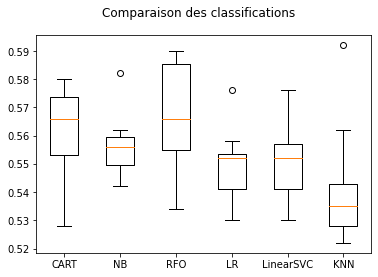

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

###Classification sur données prétraitées non équilibrées


#### Classification avec toutes les colonnes

In [ ]:
DVFvsM = dataframe3_VF_vs_M_p_ne.sample(5000)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVFvsM)
y = DVFvsM['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   148.48227334022522
CART: 0.547600 (0.020451)
Time pour NB   98.06807780265808
NB: 0.563400 (0.025204)
Time pour RFO   486.40678334236145
RFO: 0.588000 (0.018569)
Time pour LR   193.99405670166016
LR: 0.578600 (0.024496)
Time pour LinearSVC   77.30185556411743
LinearSVC: 0.581200 (0.010515)
Time pour KNN   396.6490867137909
KNN: 0.546200 (0.016672)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

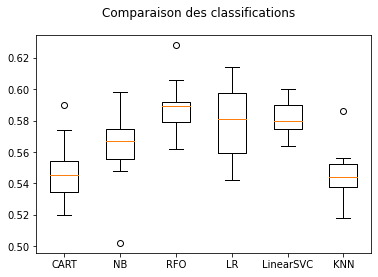

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

#### Classification sans la colonne date 

In [ ]:
DVFvsM_sans_date = DVFvsM.filter(['text','source','author','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
],df_out=True)

X = mapper.fit_transform(DVFvsM_sans_date)
y = DVFvsM_sans_date['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   255.08016681671143
CART: 0.549400 (0.019861)
Time pour NB   87.24410653114319
NB: 0.563400 (0.025970)
Time pour RFO   546.4586577415466
RFO: 0.587400 (0.013358)
Time pour LR   80.91763830184937
LR: 0.542400 (0.015590)
Time pour LinearSVC   74.48889780044556
LinearSVC: 0.581800 (0.015191)
Time pour KNN   377.222589969635
KNN: 0.567400 (0.015048)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

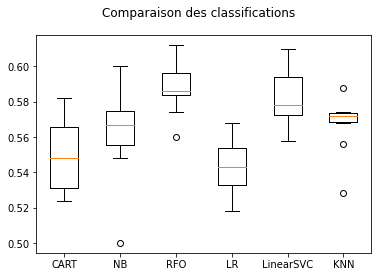

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

#### Classification sans la colonne auteur


In [ ]:
DVFvsM_sans_auteur = DVFvsM.filter(['text','source','day', 'month', 'year','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVFvsM_sans_auteur)
y = DVFvsM_sans_auteur['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   286.2345201969147
CART: 0.547400 (0.022979)
Time pour NB   62.14137315750122
NB: 0.544800 (0.026003)
Time pour RFO   541.514045715332
RFO: 0.578000 (0.014751)
Time pour LR   138.72157096862793
LR: 0.576200 (0.022494)
Time pour LinearSVC   45.813958406448364
LinearSVC: 0.576600 (0.012460)
Time pour KNN   401.6119587421417
KNN: 0.515400 (0.023513)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

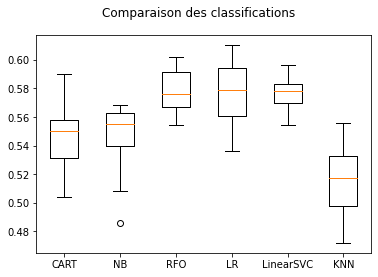

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

####Classification sans la colonne source

In [ ]:
DVFvsM_sans_source = DVFvsM.filter(['text','author','day', 'month', 'year','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('author', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVFvsM_sans_source)
y = DVFvsM_sans_source['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   153.35495805740356
CART: 0.546200 (0.023073)
Time pour NB   89.96603965759277
NB: 0.561600 (0.025327)
Time pour RFO   529.9848465919495
RFO: 0.598800 (0.018291)
Time pour LR   187.20427107810974
LR: 0.558200 (0.029058)
Time pour LinearSVC   75.31518173217773
LinearSVC: 0.585400 (0.018222)
Time pour KNN   377.8663635253906
KNN: 0.546600 (0.016614)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

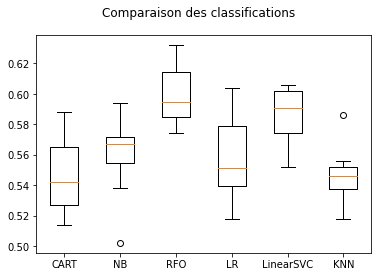

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

####Classification sans la colonne texte

In [ ]:
DVFvsM_sans_texte = DVFvsM.filter(['source','author','day', 'month', 'year','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVFvsM_sans_texte)
y = DVFvsM_sans_texte['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   0.7306687831878662
CART: 0.528200 (0.021419)
Time pour NB   0.043348073959350586
NB: 0.547800 (0.015452)
Time pour RFO   6.3307390213012695
RFO: 0.547600 (0.024278)
Time pour LR   0.3960256576538086
LR: 0.542400 (0.016045)
Time pour LinearSVC   0.12051081657409668
LinearSVC: 0.543200 (0.016786)
Time pour KNN   0.36093997955322266
KNN: 0.546400 (0.016439)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

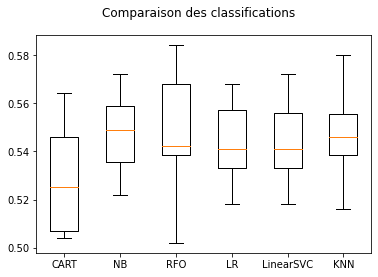

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

###Classification sur données équilibrées et prétraitées


#### Classification avec toutes les colonnes

In [ ]:
DVFvsM = dataframe_Demi_VF_vs_M_equilibre.sample(5000)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVFvsM)
y = DVFvsM['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   209.4373824596405
CART: 0.597200 (0.019681)
Time pour NB   84.64454436302185
NB: 0.584800 (0.022489)
Time pour RFO   478.91428232192993
RFO: 0.624400 (0.021162)
Time pour LR   125.96925616264343
LR: 0.527800 (0.033496)
Time pour LinearSVC   67.73023200035095
LinearSVC: 0.595200 (0.014063)
Time pour KNN   373.42238426208496
KNN: 0.571800 (0.019544)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

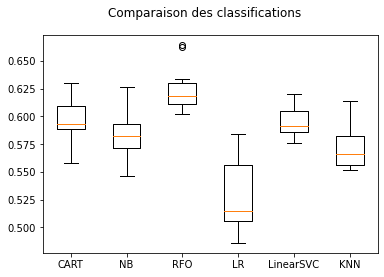

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

#### Classification sans la colonne date 

In [ ]:
DVFvsM_sans_date = DVFvsM.filter(['text','source','author','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
],df_out=True)

X = mapper.fit_transform(DVFvsM_sans_date)
y = DVFvsM_sans_date['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   334.3590657711029
CART: 0.593200 (0.017046)
Time pour NB   78.83301067352295
NB: 0.585200 (0.022311)
Time pour RFO   526.0076477527618
RFO: 0.601000 (0.020905)
Time pour LR   138.55148029327393
LR: 0.574400 (0.036440)
Time pour LinearSVC   62.563133239746094
LinearSVC: 0.593200 (0.011214)
Time pour KNN   338.50587940216064
KNN: 0.570400 (0.022375)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

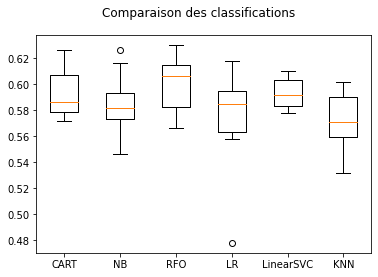

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

#### Classification sans la colonne auteur


In [ ]:
DVFvsM_sans_auteur = DVFvsM.filter(['text','source','day', 'month', 'year','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVFvsM_sans_auteur)
y = DVFvsM_sans_auteur['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   352.24832916259766
CART: 0.577000 (0.027397)
Time pour NB   55.92806386947632
NB: 0.581800 (0.017899)
Time pour RFO   499.84422516822815
RFO: 0.611600 (0.013078)
Time pour LR   146.03759860992432
LR: 0.559000 (0.047381)
Time pour LinearSVC   39.5335488319397
LinearSVC: 0.600600 (0.018996)
Time pour KNN   356.9314136505127
KNN: 0.542200 (0.019255)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

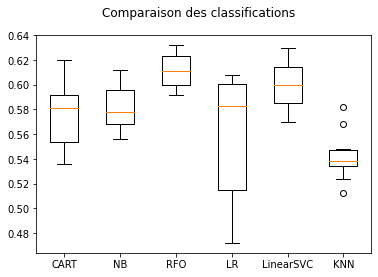

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

####Classification sans la colonne source

In [ ]:
DVFvsM_sans_source = DVFvsM.filter(['text','author','day', 'month', 'year','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('author', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVFvsM_sans_source)
y = DVFvsM_sans_source['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   209.60260319709778
CART: 0.602000 (0.020357)
Time pour NB   81.16236662864685
NB: 0.585000 (0.021712)
Time pour RFO   449.95274806022644
RFO: 0.614200 (0.013754)
Time pour LR   123.81881141662598
LR: 0.527600 (0.036131)
Time pour LinearSVC   63.95542788505554
LinearSVC: 0.595000 (0.013719)
Time pour KNN   334.02868819236755
KNN: 0.571600 (0.019304)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

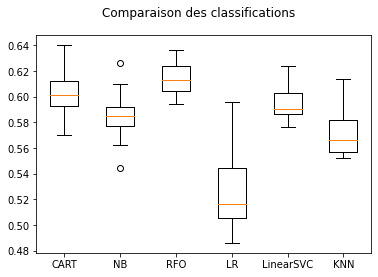

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

####Classification sans la colonne texte

In [ ]:
DVFvsM_sans_texte = DVFvsM.filter(['source','author','day', 'month', 'year','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVFvsM_sans_texte)
y = DVFvsM_sans_texte['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   0.18605685234069824
CART: 0.589200 (0.022596)
Time pour NB   0.04035329818725586
NB: 0.502800 (0.009042)
Time pour RFO   6.405239105224609
RFO: 0.604200 (0.021990)
Time pour LR   0.2711801528930664
LR: 0.503200 (0.013393)
Time pour LinearSVC   0.16169023513793945
LinearSVC: 0.519200 (0.025079)
Time pour KNN   0.3487837314605713
KNN: 0.572000 (0.018931)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

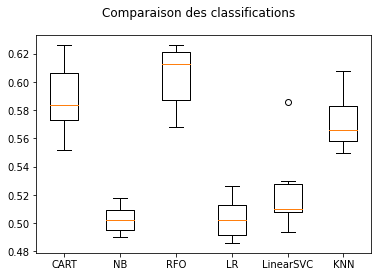

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

## Classification VRAI vs FAUX vs MIXTURE 

###Classification sur données brutes

#### Classification avec toutes les colonnes

In [ ]:
DVvsFvsM = dataframe3_V_vs_F_vs_M_brut.sample(5000)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
  ('date', LabelEncoder()),],df_out=True)

X = mapper.fit_transform(DVvsFvsM)
y = DVvsFvsM['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   346.52704524993896
CART: 0.492200 (0.018643)
Time pour NB   179.7751121520996
NB: 0.201600 (0.024541)
Time pour RFO   674.8413326740265
RFO: 0.573400 (0.018699)
Time pour LR   742.8328278064728
LR: 0.567800 (0.027487)
Time pour LinearSVC   156.96025705337524
LinearSVC: 0.562800 (0.023103)
Time pour KNN   657.5830149650574
KNN: 0.483800 (0.026973)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

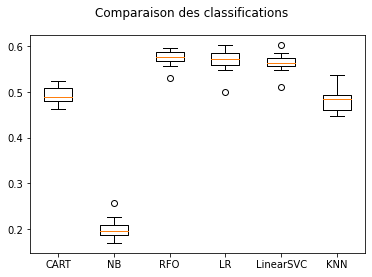

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

#### Classification sans la colonne date


In [ ]:
DVvsFvsM_sans_date = DVvsFvsM.filter(['text','source','author','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('author', LabelEncoder())
,],df_out=True)

X = mapper.fit_transform(DVvsFvsM_sans_date)
y = DVvsFvsM_sans_date['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   288.34169912338257
CART: 0.501400 (0.023342)
Time pour NB   129.6915738582611
NB: 0.194800 (0.026821)
Time pour RFO   674.5084519386292
RFO: 0.564200 (0.019172)
Time pour LR   725.6037349700928
LR: 0.567200 (0.013212)
Time pour LinearSVC   105.97590160369873
LinearSVC: 0.562200 (0.023689)
Time pour KNN   511.3409569263458
KNN: 0.509400 (0.008991)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

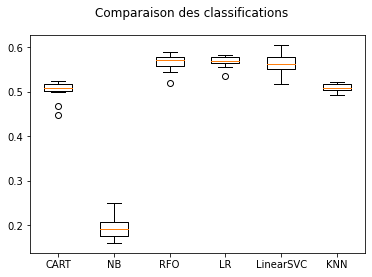

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

#### Classification sans la colonne auteur 


In [ ]:
DVvsFvsM_sans_auteur = DVvsFvsM.filter(['text','source','date','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('date', LabelEncoder()),],df_out=True)

X = mapper.fit_transform(DVvsFvsM_sans_auteur)
y = DVvsFvsM_sans_auteur['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   407.9397327899933
CART: 0.480200 (0.020812)
Time pour NB   173.2599151134491
NB: 0.201800 (0.024322)
Time pour RFO   681.3441443443298
RFO: 0.572200 (0.020716)
Time pour LR   469.2170853614807
LR: 0.557800 (0.021917)
Time pour LinearSVC   143.96182250976562
LinearSVC: 0.562200 (0.024470)
Time pour KNN   586.3523187637329
KNN: 0.452800 (0.022525)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

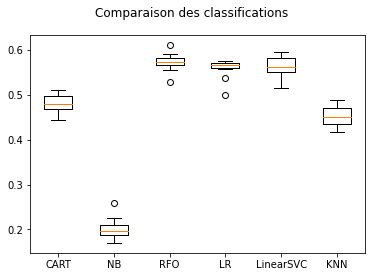

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

####Classification sans la colonne source

In [ ]:
DVvsFvsM_sans_source = DVvsFvsM.filter(['text','author','date','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('author', LabelEncoder()),
  ('date', LabelEncoder()),],df_out=True)

X = mapper.fit_transform(DVvsFvsM_sans_source)
y = DVvsFvsM_sans_source['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   336.34557580947876
CART: 0.488400 (0.018304)
Time pour NB   180.9182870388031
NB: 0.198200 (0.026328)
Time pour RFO   664.4510152339935
RFO: 0.574000 (0.012806)
Time pour LR   595.0680391788483
LR: 0.558200 (0.021917)
Time pour LinearSVC   168.4244794845581
LinearSVC: 0.556400 (0.023661)
Time pour KNN   636.1442384719849
KNN: 0.483800 (0.026973)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

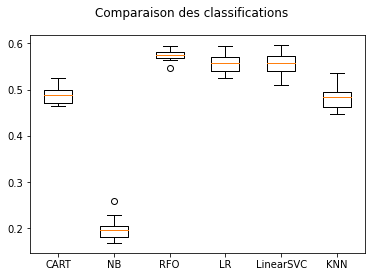

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

####Classification sans la colonne texte

In [ ]:
DVvsFvsM_sans_texte = DVvsFvsM.filter(['source','author','date','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
  ('date', LabelEncoder()),],df_out=True)

X = mapper.fit_transform(DVvsFvsM_sans_texte)
y = DVvsFvsM_sans_texte['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   0.19951462745666504
CART: 0.462200 (0.025083)
Time pour NB   0.04365086555480957
NB: 0.550600 (0.020882)
Time pour RFO   7.3412439823150635
RFO: 0.512800 (0.028624)
Time pour LR   0.6686885356903076
LR: 0.547800 (0.021605)
Time pour LinearSVC   0.11612343788146973
LinearSVC: 0.547200 (0.021395)
Time pour KNN   0.33440589904785156
KNN: 0.483600 (0.026043)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

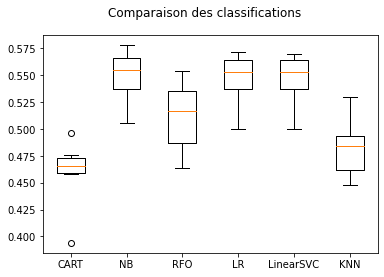

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

###Classification sur données prétraitées non équilibrées


#### Classification avec toutes les colonnes

In [ ]:
DVvsFvsM = dataframe3_V_vs_F_vs_M_p_ne.sample(5000)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVvsFvsM)
y = DVvsFvsM['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   428.64427161216736
CART: 0.508000 (0.019677)
Time pour NB   103.3841609954834
NB: 0.192600 (0.017275)
Time pour RFO   605.6679527759552
RFO: 0.578200 (0.030821)
Time pour LR   954.3650162220001
LR: 0.560000 (0.027262)
Time pour LinearSVC   80.9141173362732
LinearSVC: 0.552600 (0.031408)
Time pour KNN   415.7444860935211
KNN: 0.495200 (0.022666)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

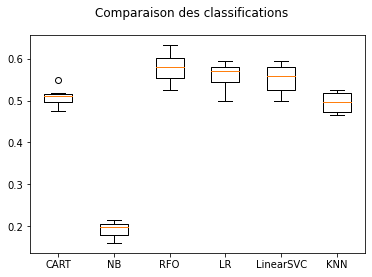

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

#### Classification sans la colonne date


In [ ]:
DVvsFvsM_sans_date = DVvsFvsM.filter(['text','source','author','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('author', LabelEncoder())
,],df_out=True)

X = mapper.fit_transform(DVvsFvsM_sans_date)
y = DVvsFvsM_sans_date['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   345.40404891967773
CART: 0.511400 (0.018784)
Time pour NB   102.87159538269043
NB: 0.193200 (0.016473)
Time pour RFO   624.7151067256927
RFO: 0.574400 (0.026120)
Time pour LR   548.9109125137329
LR: 0.558600 (0.037937)
Time pour LinearSVC   89.49511551856995
LinearSVC: 0.564000 (0.034491)
Time pour KNN   404.0046720504761
KNN: 0.519800 (0.014490)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

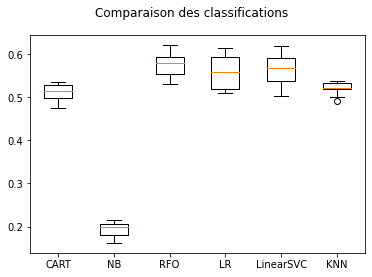

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

#### Classification sans la colonne auteur 


In [ ]:
DVvsFvsM_sans_auteur = DVvsFvsM.filter(['text','source','day', 'month', 'year','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVvsFvsM_sans_auteur)
y = DVvsFvsM_sans_auteur['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   528.9436731338501
CART: 0.484000 (0.018396)
Time pour NB   75.02412176132202
NB: 0.470400 (0.010229)
Time pour RFO   613.9543859958649
RFO: 0.570400 (0.031885)
Time pour LR   744.3659949302673
LR: 0.560000 (0.032508)
Time pour LinearSVC   68.6686851978302
LinearSVC: 0.553000 (0.031664)
Time pour KNN   358.22226548194885
KNN: 0.465200 (0.015626)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

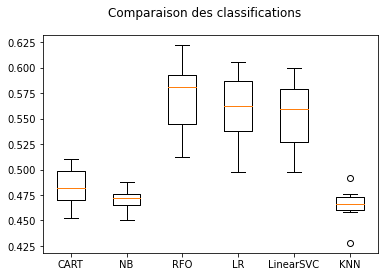

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

####Classification sans la colonne source

In [ ]:
DVvsFvsM_sans_source = DVvsFvsM.filter(['text','author','day', 'month', 'year','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('author', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVvsFvsM_sans_source)
y = DVvsFvsM_sans_source['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   394.85650968551636
CART: 0.512200 (0.022045)
Time pour NB   91.15239357948303
NB: 0.191800 (0.016528)
Time pour RFO   586.4026162624359
RFO: 0.577000 (0.025880)
Time pour LR   980.5677018165588
LR: 0.555600 (0.030170)
Time pour LinearSVC   69.80501341819763
LinearSVC: 0.550000 (0.031825)
Time pour KNN   363.4051856994629
KNN: 0.495200 (0.022436)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

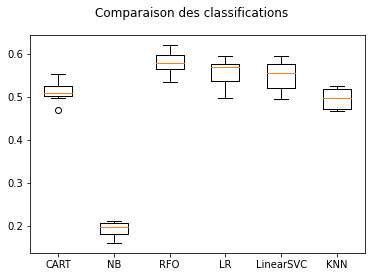

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

####Classification sans la colonne texte

In [ ]:
DVvsFvsM_sans_texte = DVvsFvsM.filter(['source','author','day', 'month', 'year','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVvsFvsM_sans_texte)
y = DVvsFvsM_sans_texte['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   0.19203901290893555
CART: 0.465200 (0.023276)
Time pour NB   0.0471186637878418
NB: 0.550400 (0.031417)
Time pour RFO   6.486283302307129
RFO: 0.539800 (0.028558)
Time pour LR   1.191176176071167
LR: 0.549600 (0.031620)
Time pour LinearSVC   0.13114213943481445
LinearSVC: 0.549600 (0.031620)
Time pour KNN   0.3721282482147217
KNN: 0.497600 (0.022015)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

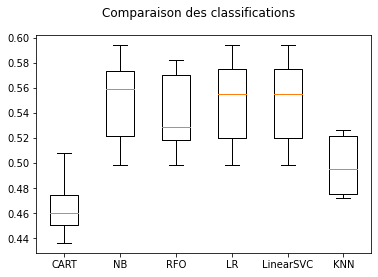

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

###Classification sur données équilibrées et prétraitées


#### Classification avec toutes les colonnes

In [ ]:
DVvsFvsM = dataframeVFM_equilibre.sample(5000)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVvsFvsM)
y = DVvsFvsM['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   113.66711068153381
CART: 0.515200 (0.020711)
Time pour NB   89.52373814582825
NB: 0.409800 (0.021456)
Time pour RFO   525.4203426837921
RFO: 0.551000 (0.020885)
Time pour LR   798.8980829715729
LR: 0.397400 (0.091127)
Time pour LinearSVC   56.20405101776123
LinearSVC: 0.399400 (0.063838)
Time pour KNN   362.67393827438354
KNN: 0.438200 (0.016357)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

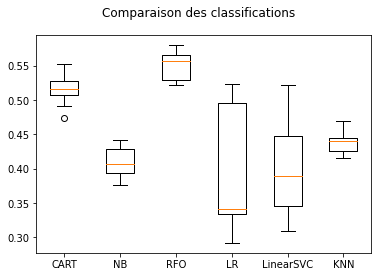

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

#### Classification sans la colonne date


In [ ]:
DVvsFvsM_sans_date = DVvsFvsM.filter(['text','source','author','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('author', LabelEncoder())
,],df_out=True)

X = mapper.fit_transform(DVvsFvsM_sans_date)
y = DVvsFvsM_sans_date['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   152.04696679115295
CART: 0.512600 (0.020021)
Time pour NB   73.7152898311615
NB: 0.409800 (0.021212)
Time pour RFO   561.5362920761108
RFO: 0.553000 (0.015601)
Time pour LR   299.9309666156769
LR: 0.406400 (0.093662)
Time pour LinearSVC   70.11404633522034
LinearSVC: 0.531800 (0.017262)
Time pour KNN   331.3121407032013
KNN: 0.468200 (0.019869)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

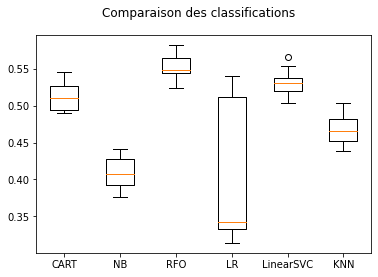

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

#### Classification sans la colonne auteur 


In [ ]:
DVvsFvsM_sans_auteur = DVvsFvsM.filter(['text','source','day', 'month', 'year','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('source', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVvsFvsM_sans_auteur)
y = DVvsFvsM_sans_auteur['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   170.47813534736633
CART: 0.490800 (0.018702)
Time pour NB   93.95633363723755
NB: 0.492800 (0.012592)
Time pour RFO   528.864828824997
RFO: 0.549400 (0.020299)
Time pour LR   451.77348017692566
LR: 0.384400 (0.080983)
Time pour LinearSVC   74.17129468917847
LinearSVC: 0.446800 (0.074973)
Time pour KNN   387.61075139045715
KNN: 0.432200 (0.019523)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

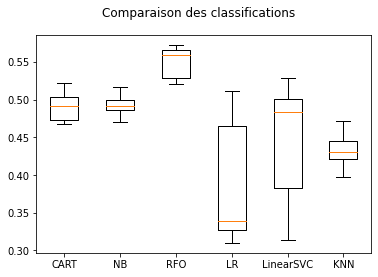

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

####Classification sans la colonne source

In [ ]:
DVvsFvsM_sans_source = DVvsFvsM.filter(['text','author','day', 'month', 'year','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('text', TfidfVectorizer(
      sublinear_tf=True,
      strip_accents='unicode',
      analyzer='word',
      token_pattern=r'\w{1,}',
      ngram_range=(1, 2),)),
  ('author', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVvsFvsM_sans_source)
y = DVvsFvsM_sans_source['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   114.456228017807
CART: 0.514600 (0.022699)
Time pour NB   75.87945818901062
NB: 0.408200 (0.020927)
Time pour RFO   517.4188058376312
RFO: 0.551000 (0.024286)
Time pour LR   558.9248960018158
LR: 0.364200 (0.073324)
Time pour LinearSVC   73.89564061164856
LinearSVC: 0.377200 (0.063499)
Time pour KNN   345.4845106601715
KNN: 0.438200 (0.016357)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

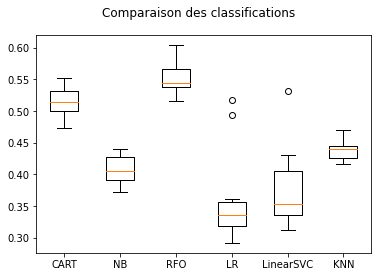

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

####Classification sans la colonne texte

In [ ]:
DVvsFvsM_sans_texte = DVvsFvsM.filter(['source','author','day', 'month', 'year','truthRating'], axis=1)

mapper = DataFrameMapper([
  ('source', LabelEncoder()),
  ('author', LabelEncoder()),
  ('day',None),
  ('month',None),
  ('year',None),],df_out=True)

X = mapper.fit_transform(DVvsFvsM_sans_texte)
y = DVvsFvsM_sans_texte['truthRating']

validation_size=0.3 #30% du jeu de données pour le train

testsize= 1-validation_size
seed=30
scoring = 'accuracy'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=validation_size, random_state=seed,test_size=testsize)

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFO', RandomForestClassifier()))
models.append(('LR',LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LinearSVC', LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3,n_jobs=-1)))

results = []
names = []

for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time.time()
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    #print (model.get_params())
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)       

Time pour CART   1.034475326538086
CART: 0.497400 (0.017822)
Time pour NB   0.04759645462036133
NB: 0.337200 (0.011179)
Time pour RFO   6.579424142837524
RFO: 0.498200 (0.015270)
Time pour LR   0.8682835102081299
LR: 0.325000 (0.017983)
Time pour LinearSVC   0.1309833526611328
LinearSVC: 0.325600 (0.015794)
Time pour KNN   0.3668093681335449
KNN: 0.439400 (0.016421)


[Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'RFO'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'LinearSVC'),
 Text(0, 0, 'KNN')]

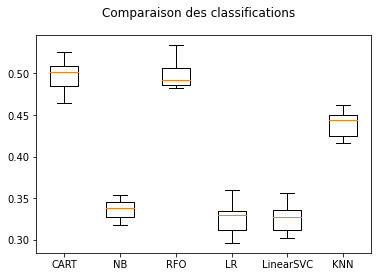

In [ ]:
fig=plt.figure()
fig.suptitle('Comparaison des classifications')
ax=fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)